In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
# import tensorflow_hub as hub
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import zipfile
import warnings
# from d2l import tensorflow as d2l
# import json
# import ijson # alternative to json for handling larger files
import random
import shutil

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Setup Global Variables for model inputs

In [3]:
class G:
    TRAINING_SPLIT = 0.85
    VALIDATION_SPLIT = 0.1
    EPOCHS=50
    LEARNING_RATE = 0.0001
    IM_WIDTH = 80
    IM_HEIGHT = 80
    BATCH_SIZE = 100

Process Data - Each image is 4000 x 80 x 80 RGB images with either a "ship" or "no-ship" classification.
Provided is a zipped directory shipsnet.zip that contains the entire dataset as .png image chips. Each individual image filename follows a specific format: {label} __ {scene id} __ {longitude} _ {latitude}.png

    - label: Valued 1 or 0, representing the "ship" class and "no-ship" class, respectively.
    - scene id: The unique identifier of the PlanetScope visual scene the image chip was extracted from. The scene id can be used with the Planet API to discover and download the entire scene.
    - longitude_latitude: The longitude and latitude coordinates of the image center point, with values separated by a single underscore.

The pixel value data for each 80x80 RGB image is stored as a list of 19200 integers within the data list. The first 6400 entries contain the red channel values, the next 6400 the green, and the final 6400 the blue. The image is stored in row-major order, so that the first 80 entries of the array are the red channel values of the first row of the image. The list values at index i in labels, scene_ids, and locations each correspond to the i-th image in the data list.


In [4]:
# Setup directories
base_dir = os.path.join(os.getcwd())

# Unzip raw data
data_dir = os.path.join(os.path.join(os.getcwd(), 'shipsnet', 'shipsnet'))
if not os.path.exists(data_dir):
    zip_ref = zipfile.ZipFile('zipped_data/archive.zip')
    zip_ref.extractall(base_dir)

def create_train_test_dirs(base_dir):
    '''
    Setup training, validation, and test directories
    '''
    
    # Setup training directory
    os.makedirs(os.path.join(base_dir, os.path.join('train','ship')))
    os.makedirs(os.path.join(base_dir, os.path.join('train','not_a_ship')))

    # Setup validation directory
    os.makedirs(os.path.join(base_dir, os.path.join('validation','ship')))
    os.makedirs(os.path.join(base_dir, os.path.join('validation','not_a_ship')))

    # Setup testing directory
    os.makedirs(os.path.join(base_dir, os.path.join('test','ship')))
    os.makedirs(os.path.join(base_dir, os.path.join('test','not_a_ship')))

try:
  create_train_test_dirs(base_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

You should not be seeing this since the upper directory is removed beforehand


In [5]:
# Make sure data is as expected
print(data_dir)
print(f"There are {len(os.listdir(data_dir))} images of ships and non-ships.")

c:\Users\robby\Desktop\SatelliteImageryClassifier\shipsnet\shipsnet
There are 4000 images of ships and non-ships.


Sort shipsnet data into 'ship' and 'not_a_ship' folders

In [6]:
# Create formatted data folders for sorting ship and not a ship
ship_data_dir = os.path.join(base_dir, os.path.join('shipsnet_formatted','ship'))
not_a_ship_data_dir = os.path.join(base_dir, os.path.join('shipsnet_formatted','not_a_ship'))

if not os.path.exists(os.path.join(base_dir, 'shipsnet_formatted')):
    os.makedirs(ship_data_dir)
    os.makedirs(not_a_ship_data_dir)

for filename in os.listdir(data_dir):
    filepath = os.path.join(data_dir, filename)
    print(filepath)
    if filename[0] == '0':
        # Move into not a ship folder
        shutil.copyfile(os.path.join(data_dir, filename), os.path.join(not_a_ship_data_dir, filename))
    elif filename[0] == '1':
        # Move into ship folder
        shutil.copyfile(os.path.join(data_dir, filename), os.path.join(ship_data_dir, filename))
    else:
        raise Exception(f"Cannot understand if filename contains label for filename: {filename}")

print("Done")
   

c:\Users\robby\Desktop\SatelliteImageryClassifier\shipsnet\shipsnet\0__20150718_184300_090b__-122.35324421973536_37.772113980272394.png
c:\Users\robby\Desktop\SatelliteImageryClassifier\shipsnet\shipsnet\0__20150718_184300_090b__-122.38458613431831_37.763521076612484.png
c:\Users\robby\Desktop\SatelliteImageryClassifier\shipsnet\shipsnet\0__20150718_184300_090b__-122.40477488428849_37.8071040053892.png
c:\Users\robby\Desktop\SatelliteImageryClassifier\shipsnet\shipsnet\0__20150718_184300_090b__-122.42663861582857_37.80913223576201.png
c:\Users\robby\Desktop\SatelliteImageryClassifier\shipsnet\shipsnet\0__20150720_184302_0906__-122.21893759782994_37.87172273326103.png
c:\Users\robby\Desktop\SatelliteImageryClassifier\shipsnet\shipsnet\0__20150830_000650_0b07__-122.37967271362145_37.76049394246638.png
c:\Users\robby\Desktop\SatelliteImageryClassifier\shipsnet\shipsnet\0__20150830_000650_0b07__-122.40480193174041_37.757000251300894.png
c:\Users\robby\Desktop\SatelliteImageryClassifier\shi

Code the `split_data` function which takes in the following arguments:
- SOURCE: directory containing the files

- TRAINING: directory that a portion of the files will be copied to (will be used for training)
- TESTING: directory that a portion of the files will be copied to (will be used for testing)
- SPLIT SIZE: to determine the portion

The files should be randomized, so that the training set is a random sample of the files, and the test set is made up of the remaining files.

For example, if `SOURCE` is `PetImages/Cat`, and `SPLIT` SIZE is .9 then 90% of the images in `PetImages/Cat` will be copied to the `TRAINING` dir
and 10% of the images will be copied to the `TESTING` dir.

All images should be checked before the copy, so if they have a zero file length, they will be omitted from the copying process. If this is the case then your function should print out a message such as `"filename is zero length, so ignoring."`. **You should perform this check before the split so that only non-zero images are considered when doing the actual split.**


Hints:

- `os.listdir(DIRECTORY)` returns a list with the contents of that directory.

- `os.path.getsize(PATH)` returns the size of the file

- `copyfile(source, destination)` copies a file from source to destination

- `random.sample(list, len(list))` shuffles a list

In [7]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  ''' 
  Copy files from SOURCE to TRAINING and TESTING/VALIDATION set
  '''
  SOURCE_LIST = os.listdir(SOURCE)
  SOURCE_LIST = random.sample(SOURCE_LIST, len(SOURCE_LIST))

  for i, filename in enumerate(SOURCE_LIST):
    if os.path.getsize(os.path.join(SOURCE, filename)) == 0:
      print(f"{filename} is zero length, so ignoring.")
    else:
      # Determine whether to copy files into TRAINING DIR or VALIDATION/TESTING DIR
      if i <= int(len(SOURCE_LIST)*SPLIT_SIZE):
        shutil.copyfile(os.path.join(SOURCE, filename), os.path.join(TRAINING, filename))
      else:
        shutil.copyfile(os.path.join(SOURCE, filename), os.path.join(TESTING, filename))

def split_data3(SOURCE, TRAINING, VALIDATION, TESTING, TRAINING_SPLIT_SIZE, VALIDATION_SPLIT_SIZE):
  ''' 
  Copy files from SOURCE to TRAINING, TESTING, and VALIDATION folders
  '''
  SOURCE_LIST = os.listdir(SOURCE)
  SOURCE_LIST = random.sample(SOURCE_LIST, len(SOURCE_LIST))

  for i, filename in enumerate(SOURCE_LIST):
    if os.path.getsize(os.path.join(SOURCE, filename)) == 0:
      print(f"{filename} is zero length, so ignoring.")
    else:
      # Determine whether to copy files into TRAINING DIR or VALIDATION DIR or TESTING DIR
      if i <= int(len(SOURCE_LIST)*TRAINING_SPLIT_SIZE):
        shutil.copyfile(os.path.join(SOURCE, filename), os.path.join(TRAINING, filename))
      elif i <= int(len(SOURCE_LIST)*(TRAINING_SPLIT_SIZE + VALIDATION_SPLIT_SIZE)):
        shutil.copyfile(os.path.join(SOURCE, filename), os.path.join(VALIDATION, filename))
      else:
        shutil.copyfile(os.path.join(SOURCE, filename), os.path.join(TESTING, filename))

In [8]:
# Get top level directories
SOURCE_TRAINING_SHIP = ship_data_dir
SOURCE_TRAINING_NOTASHIP = not_a_ship_data_dir

TRAINING_DIR = os.path.join(base_dir, 'train')
VALIDATION_DIR =  os.path.join(base_dir, 'validation')
TESTING_DIR = os.path.join(base_dir, 'test')

# Create variables for storing training, validation, and testing directories
TRAINING_SHIP_DIR = os.path.join(TRAINING_DIR, 'ship')
TRAINING_NOTASHIP_DIR = os.path.join(TRAINING_DIR, 'not_a_ship')

VALIDATION_SHIP_DIR = os.path.join(VALIDATION_DIR, 'ship')
VALIDATION_NOTASHIP_DIR = os.path.join(VALIDATION_DIR, 'not_a_ship')

TESTING_SHIP_DIR = os.path.join(TESTING_DIR, 'ship')
TESTING_NOTASHIP_DIR = os.path.join(TESTING_DIR, 'not_a_ship')

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_SHIP_DIR)) > 0:
  for file in os.scandir(TRAINING_SHIP_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_NOTASHIP_DIR)) > 0:
  for file in os.scandir(TRAINING_NOTASHIP_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_SHIP_DIR)) > 0:
  for file in os.scandir(VALIDATION_SHIP_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_NOTASHIP_DIR)) > 0:
  for file in os.scandir(VALIDATION_NOTASHIP_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_SHIP_DIR)) > 0:
  for file in os.scandir(TESTING_SHIP_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_NOTASHIP_DIR)) > 0:
  for file in os.scandir(TESTING_NOTASHIP_DIR):
    os.remove(file.path)


# # Run split_data function to correctly copy/move SHIP files
# split_data(SOURCE=SOURCE_TRAINING_SHIP, TRAINING=TRAINING_SHIP_DIR, TESTING=VALIDATION_SHIP_DIR, SPLIT_SIZE=G.TRAINING_SPLIT)

# # Run split_data function to correctly copy/move NOT A SHIP files
# split_data(SOURCE=SOURCE_TRAINING_NOTASHIP, TRAINING=TRAINING_NOTASHIP_DIR, TESTING=VALIDATION_NOTASHIP_DIR, SPLIT_SIZE=G.TRAINING_SPLIT)

# Run split_data function to correctly copy/move SHIP files
split_data3(SOURCE=SOURCE_TRAINING_SHIP, TRAINING=TRAINING_SHIP_DIR, VALIDATION=VALIDATION_SHIP_DIR, TESTING=TESTING_SHIP_DIR, 
                TRAINING_SPLIT_SIZE=G.TRAINING_SPLIT, VALIDATION_SPLIT_SIZE=G.VALIDATION_SPLIT)

# Run split_data function to correctly copy/move NOT A SHIP files
split_data3(SOURCE=SOURCE_TRAINING_NOTASHIP, TRAINING=TRAINING_NOTASHIP_DIR, VALIDATION=VALIDATION_NOTASHIP_DIR, TESTING=TESTING_NOTASHIP_DIR,
                TRAINING_SPLIT_SIZE=G.TRAINING_SPLIT, VALIDATION_SPLIT_SIZE=G.VALIDATION_SPLIT)

print('Done')

Done


In [9]:
# Print out how many files are in each directory
print(f'SOURCE_TRAINING_SHIP contains a total of {len(os.listdir(SOURCE_TRAINING_SHIP))} images')
print(f'- TRAINING_SHIP_DIR contains {len(os.listdir(TRAINING_SHIP_DIR))} images of ships')
print(f'- VALIDATION_SHIP_DIR contains {len(os.listdir(VALIDATION_SHIP_DIR))} images of ships')
print(f'- TESTING_SHIP_DIR contains {len(os.listdir(TESTING_SHIP_DIR))} images of ships\n')
print(f'SOURCE_TRAINING_NOTASHIP contains a total of {len(os.listdir(SOURCE_TRAINING_NOTASHIP))} images')
print(f'- TRAINING_NOTASHIP_DIR contains {len(os.listdir(TRAINING_NOTASHIP_DIR))} images of not a ship')
print(f'- VALIDATION_NOTASHIP_DIR contains {len(os.listdir(VALIDATION_NOTASHIP_DIR))} images of not a ship')
print(f'- TESTING_NOTASHIP_DIR contains {len(os.listdir(TESTING_NOTASHIP_DIR))} images of not a ship\n')
print(f'Training data split: {G.TRAINING_SPLIT*100}% of total data')
print(f'Validation data split: {G.VALIDATION_SPLIT*100}% of total data')
print('Testing data split: {:0.1f}% total data'.format(((1.0 - (G.VALIDATION_SPLIT + G.TRAINING_SPLIT)))*100.0))

SOURCE_TRAINING_SHIP contains a total of 1000 images
- TRAINING_SHIP_DIR contains 851 images of ships
- VALIDATION_SHIP_DIR contains 100 images of ships
- TESTING_SHIP_DIR contains 49 images of ships

SOURCE_TRAINING_NOTASHIP contains a total of 3000 images
- TRAINING_NOTASHIP_DIR contains 2551 images of not a ship
- VALIDATION_NOTASHIP_DIR contains 300 images of not a ship
- TESTING_NOTASHIP_DIR contains 149 images of not a ship

Training data split: 85.0% of total data
Validation data split: 10.0% of total data
Testing data split: 5.0% total data


Take a look at some of the images of the dataset:

Sample ship image:


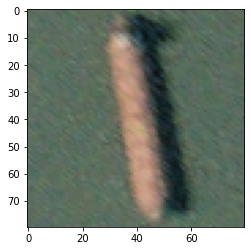


Sample not a ship image:


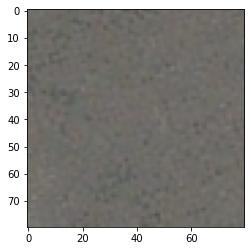

In [10]:
from tensorflow.keras.preprocessing.image import load_img

print("Sample ship image:")
plt.imshow(load_img(f"{os.path.join(SOURCE_TRAINING_SHIP, os.listdir(SOURCE_TRAINING_SHIP)[0])}"))
plt.show()

print("\nSample not a ship image:")
plt.imshow(load_img(f"{os.path.join(SOURCE_TRAINING_NOTASHIP, os.listdir(SOURCE_TRAINING_NOTASHIP)[0])}"))
plt.show()

Use ImageDataGenerator class to prepare data

In [11]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TESTING_DIR):

  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(#rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=G.BATCH_SIZE,
                                                      class_mode='binary',
                                                      target_size=(G.IM_WIDTH, G.IM_HEIGHT))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator()#rescale = 1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=G.BATCH_SIZE,
                                                                class_mode='binary',
                                                                target_size=(G.IM_WIDTH, G.IM_HEIGHT))

  # Instantiate the ImageDataGenerator class
  testing_generator = ImageDataGenerator()#rescale = 1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  testing_generator = testing_generator.flow_from_directory(TESTING_DIR,
                                                            target_size= (G.IM_WIDTH, G.IM_HEIGHT),
                                                            class_mode='binary',
                                                            shuffle=False,
                                                            batch_size = G.BATCH_SIZE)

  return train_generator, validation_generator, testing_generator

In [12]:
# Test your generators
train_generator, validation_generator, testing_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR, TESTING_DIR)

Found 3402 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 198 images belonging to 2 classes.


# Create the Model

In [13]:
def create_model():

  model = tf.keras.models.Sequential([ 
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(G.IM_WIDTH, G.IM_HEIGHT, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid'),
  ])
  
  ## Determine which optimizer to use

  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=G.LEARNING_RATE),
                loss='binary_crossentropy',
                metrics=['accuracy']) 
          
  # model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=G.LEARNING_RATE),
  #               loss='binary_crossentropy',
  #               metrics=['accuracy']) 
              
  # model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=G.LEARNING_RATE),
  #               loss='binary_crossentropy',
  #               metrics=['accuracy']) 

  return model

Create callback

In [14]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.95:
            print("\nReached 95.0% accuracy so cancelling training!")
            self.model.stop_training = True

Print out summary of model

In [15]:
# Get the untrained model
model = create_model()

# Print out the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 39, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 39, 39, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                             
                                                        

Train the model

In [16]:
# Train the model
history = model.fit(train_generator,
                    epochs=G.EPOCHS,
                    #steps_per_epoch = 35,
                    #validation_steps = 15,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[myCallback()])

Epoch 1/50
35/35 [==============================] - 25s 560ms/step - loss: 0.6637 - accuracy: 0.7619 - val_loss: 0.4761 - val_accuracy: 0.7875
Epoch 2/50
35/35 [==============================] - 8s 219ms/step - loss: 0.3844 - accuracy: 0.8210 - val_loss: 0.6946 - val_accuracy: 0.7825
Epoch 3/50
35/35 [==============================] - 8s 240ms/step - loss: 0.3297 - accuracy: 0.8510 - val_loss: 0.4188 - val_accuracy: 0.8250
Epoch 4/50
35/35 [==============================] - 9s 245ms/step - loss: 0.2792 - accuracy: 0.8745 - val_loss: 0.3845 - val_accuracy: 0.8200
Epoch 5/50
35/35 [==============================] - 8s 239ms/step - loss: 0.2544 - accuracy: 0.8880 - val_loss: 0.3366 - val_accuracy: 0.8375
Epoch 6/50
35/35 [==============================] - 8s 230ms/step - loss: 0.2426 - accuracy: 0.8951 - val_loss: 0.2764 - val_accuracy: 0.8650
Epoch 7/50
35/35 [==============================] - 8s 225ms/step - loss: 0.2543 - accuracy: 0.8886 - val_loss: 0.2931 - val_accuracy: 0.8625
Epoch

# Plot the history values during model training

<Figure size 432x288 with 0 Axes>

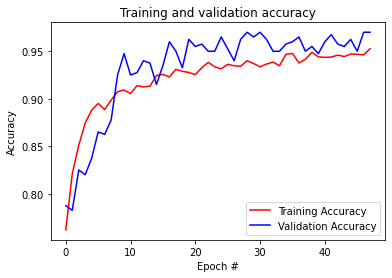

<Figure size 432x288 with 0 Axes>

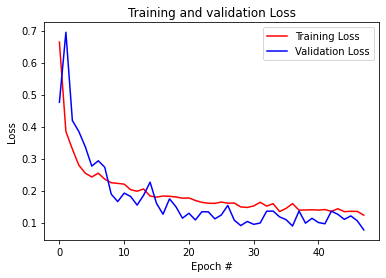

In [17]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
acc_fig = plt.figure()
acc_fig, ax = plt.subplots()
ax.plot(epochs, acc, 'r', label='Training Accuracy')
ax.plot(epochs, val_acc, 'b', label='Validation Accuracy')
ax.set_title('Training and validation accuracy')
ax.set_xlabel('Epoch #')
ax.set_ylabel('Accuracy')
ax.legend()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
loss_fig = plt.figure()
loss_fig, ax = plt.subplots()
ax.plot(epochs, loss, 'r', label='Training Loss')
ax.plot(epochs, val_loss, 'b', label='Validation Loss')
ax.set_title('Training and validation Loss')
ax.set_xlabel('Epoch #')
ax.set_ylabel('Loss')
ax.legend()

Evaluate on Test dataset

In [18]:
test_evaluate = model.evaluate(testing_generator, batch_size=10, verbose=1)

2/2 [==============================] - 1s 851ms/step - loss: 0.0557 - accuracy: 0.9848


Predict on Test dataset

In [19]:
preds = model.predict(testing_generator, batch_size=10, verbose=1)
preds_list = np.array([1 if pred >= 0.5 else 0 for pred in preds])
test_SHIP = [(filename, int(filename[0])) for filename in os.listdir(TESTING_SHIP_DIR)]
test_NOTASHIP = [(filename, int(filename[0])) for filename in os.listdir(TESTING_NOTASHIP_DIR)]
test = test_NOTASHIP
test.extend(test_SHIP)

print(preds_list)
print(preds_list.shape)
print(np.array(test_SHIP).shape)
print(np.array(test_NOTASHIP).shape)
print(np.array(test).shape)

2/2 [==============================] - 0s 76ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1]
(198,)
(49, 2)
(198, 2)
(198, 2)


Print out incorrect predictions on test dataset

Incorrect prediction for file: 'test/not_a_ship/0__20170226_180944_0e26__-122.28016173459612_37.766687940895295.png'
Raw Prediction: [0.5634405] | Prediction: 1 | True Label: 0


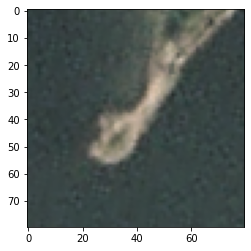

Incorrect prediction for file: 'test/ship/1__20160820_233143_0c53__-122.34848736520453_37.77073581030887.png'
Raw Prediction: [0.42386752] | Prediction: 0 | True Label: 1


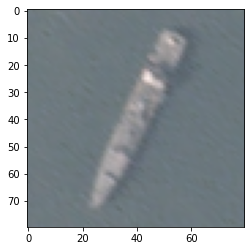

Incorrect prediction for file: 'test/ship/1__20171107_181615_0f22__-122.35043213027565_37.74700597830246.png'
Raw Prediction: [0.08111913] | Prediction: 0 | True Label: 1


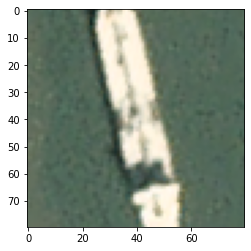

Model mislabeled 3 of out 198 images


In [20]:
count = 0
for i, label_filename in enumerate(test):
    #------------------------------------------------
    # Plot predictions and true labels for test dataset
    #------------------------------------------------

    filename = label_filename[0]
    label = label_filename[1]

    if preds_list[i] != label:
        count += 1
        if label == 0:
            print(f'Incorrect prediction for file: \'test/not_a_ship/{filename}\'')
            print(f"Raw Prediction: {preds[i]} | Prediction: {preds_list[i]} | True Label: {label}")
            plt.imshow(load_img(f"{os.path.join(TESTING_NOTASHIP_DIR, filename)}"))
            plt.show()
        else:
            print(f'Incorrect prediction for file: \'test/ship/{filename}\'')
            print(f"Raw Prediction: {preds[i]} | Prediction: {preds_list[i]} | True Label: {label}")
            plt.imshow(load_img(f"{os.path.join(TESTING_SHIP_DIR, filename)}"))
            plt.show()

print(f'Model mislabeled {count} of out {len(test)} images')

Print out all predictions on test dataset

In [21]:
# for i, label_filename in enumerate(test):
#     #------------------------------------------------
#     # Plot predictions and true labels for test dataset
#     #------------------------------------------------

#     filename = label_filename[0]
#     label = label_filename[1]

#     if label == 0:
#         print(f"Raw Prediction: {preds[i]} | Prediction: {preds_list[i]} | True Label: {label}")
#         plt.imshow(load_img(f"{os.path.join(TESTING_NOTASHIP_DIR, filename)}"))
#         plt.show()
#     else:
#         print(f"Raw Prediction: {preds[i]} | Prediction: {preds_list[i]} | True Label: {label}")
#         plt.imshow(load_img(f"{os.path.join(TESTING_SHIP_DIR, filename)}"))
#         plt.show()

Predict a single image

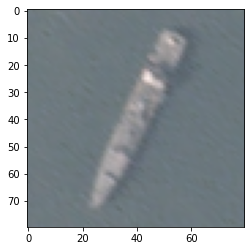

(1, 80, 80, 3)
1/1 [==============================] - 0s 255ms/step
[[0.4238676]]


In [22]:
#load the image
filename = os.listdir(os.path.join(TESTING_DIR, 'ship'))[0]
filepath = os.path.join(os.path.join(TESTING_DIR, 'ship'), filename)
my_image = load_img(filepath, target_size=(G.IM_WIDTH, G.IM_HEIGHT))
plt.imshow(my_image)
plt.show()

#preprocess the image
my_image = img_to_array(my_image)
my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
print(my_image.shape)

#make the prediction
prediction = model.predict(my_image)
print(prediction)

Clear Session if needed

In [23]:
tf.keras.backend.clear_session()